## Testing transforms.py

In [615]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.plots import *
from fastai.dataset import *

In [606]:
bb =['195.927', '320.607', '954.697', '699.399']
f = 'img_02642.jpg'
PIL.Image.open("fastai/images/" + f).size

(1280, 974)

In [611]:
PATH = "data/fish/"

In [650]:
fnames,corner_labels,_,_ = parse_csv_labels(f'{PATH}trn_bb_corners_labels', skip_header=False)

In [651]:
corner_labels["img_02642.jpg"]

['699.399', '954.697', '895.326', '1275.3']

In [645]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=3)

def show_corner_bb(f='img_04908.jpg'):
    file_path = f'{PATH}images/{f}'
    bb = corner_labels[f]
    plots_from_files([file_path])
    plt.gca().add_patch(create_corner_rect(bb))

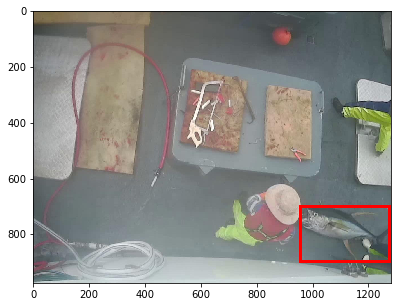

In [646]:
show_corner_bb(f = 'img_02642.jpg')

In [652]:
def get_x(f):
        file_path = f'{PATH}/images/{f}'
        im = PIL.Image.open(file_path).convert('RGB')
        return np.array(im, dtype=np.float32)/255.

In [655]:
f = 'img_02642.jpg'
x = get_x(f)
y = np.array(corner_labels[f], dtype=np.float32)
y

array([  699.399,   954.697,   895.326,  1275.3  ], dtype=float32)

In [656]:
x.shape

(974, 1280, 3)

In [657]:
corner_labels[f]

['699.399', '954.697', '895.326', '1275.3']

In [658]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=3)

def plotXY(x,y):
    plots([x])
    plt.gca().add_patch(create_rect(y))

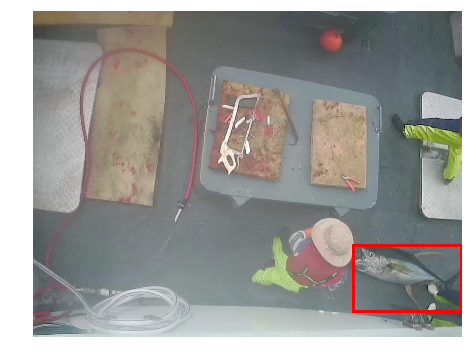

In [659]:
plotXY(x,y)

In [660]:
import enum

class TfmType(enum.Enum):
    NO = 1
    PIXEL = 2
    COORD = 3

class Transform():
    def __init__(self, tfm_y): self.tfm_y=tfm_y
    def __call__(self, x, y):
        x,y = (self.transform(x),y if self.tfm_y==TfmType.NO
                else self.transform(x,y) if self.tfm_y==TfmType.PIXEL
                else self.transform_coord(x,y))
        return x,y

## Random Dihedral

In [661]:
class RandomDihedralXY(Transform):
    def rand_gen(self):
        return random.randint(0,3), random.random()<0.5

    def transform_coord(self, x, y):
        rot_times, do_flip = self.rand_gen()
        x = self.do_transform(x, rot_times, do_flip)
        raise NotImplementedError # XXX: Handle y coord transform
        return x, y

    def transform(self, x, y=None):
        rot_times, do_flip = self.rand_gen()
        print(rot_times, do_flip)
        x = self.do_transform(x, rot_times, do_flip)
        return (x, do_transform(y, rot_times, do_flip)) if y else x

    def do_transform(self, x, rot_times, do_flip):
        x = np.rot90(x, rot_times)
        return np.fliplr(x).copy() if do_flip else x

In [477]:
trf = RandomDihedralXY(TfmType.NO)

In [490]:
xx, y = trf(x, y)

1 False


In [425]:
x.shape

(974, 1280, 3)

In [674]:
def to_bb(YY):
    YY = np.nonzero(YY)
    row1 = np.min(YY[0])
    col1 = np.min(YY[1])
    h = np.abs(YY[0][0]- YY[0][1])
    w = np.abs(YY[1][0]- YY[1][1])
    return np.array([row1, col1, row1 + h, col1 + w])

In [675]:
def tr(x, y, rot_times=1, do_flip=False):
    rows = np.rint([y[0], y[2]]).astype(int)
    cols = np.rint([y[1], y[3]]).astype(int)
    Y = np.zeros((x.shape[0], x.shape[1]))
    Y[rows, cols] = 1
    YY = np.rot90(Y, rot_times)
    xx = np.rot90(x, rot_times)
    return xx, to_bb(YY)

In [676]:
xx, yy = tr(x, y)

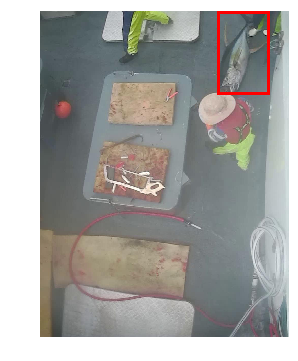

In [677]:
plotXY(xx,yy)